# Machine learning algorithm

In [131]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statistics import stdev

In [11]:
# LOAD THE DATA
# use pandas to read data as table
# index is already specified in *.txt file -> use first column as index column
artworks = pd.read_table("beautified_boxes_numeric.txt", index_col=0)
artworks

,Artwork-Id,type,district,environment,countArtists,experience,replaced,content,userRating,approval
0,32048698,5,3,3,2,1,7,2,4,1
1,39800694,5,3,3,3,2,4,1,2,0
2,80318972,4,3,2,3,2,8,2,4,0
3,74478002,4,3,3,4,1,3,2,4,0
4,71449602,5,2,4,3,2,4,2,0,0
...,...,...,...,...,...,...,...,...,...,...
745,68311402,5,4,4,2,1,6,1,3,1
746,22390811,5,1,3,2,2,6,2,5,1
747,19230282,5,5,3,1,3,6,2,5,1
748,29644044,5,3,4,2,3,8,2,3,1


In [18]:
# SET FEATURES AND LABEL

# set features and label
# features (X): "type", "district", "environment", "countArtists", "experience", "replaced", "content", "userRating"
# label (y): "approval"
# do not use for classification: "Artwork_Id"
X = artworks[["type", "district", "environment", "countArtists", "experience", "replaced", "content", "userRating"]]
y = artworks["approval"]


In [144]:
# FIND OUT OPTIMUM K FOR CLASSIFIER - CALCULATIONS

# do 10000 runs, test values of the accuracy of the classifier for k from 1 to 20
n_range = range(1, 10001)
k_range = range(1,20)

# in each run:
for n in n_range:
    # do the split
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    # make empty list to contain temporary accuracy results of the run
    scores = []

    # test the accuracy
    for k in k_range:
        # make a classifier
        knn = KNeighborsClassifier(n_neighbors = k)
        # train the classifier
        knn.fit(X_train, y_train)
        # calculate scores and append to the temporary list
        scores.append(knn.score(X_test, y_test))

    # from temporary list, get best accuracy
    b_acc = max(scores)
    # for the best accuracy, get corresponding value of k (index plus one, since index begins with 0)
    b_k = scores.index(b_acc) + 1

    # add the result to the data frame "best_accuracy" containing all of the results after the loop
    data2 = [[b_acc, b_k]]
    append_this = pd.DataFrame(data2, columns=["best_accuracy", "best_k"])
    # first loop: initiate "best_accuracy" to contain complete data. first case becomes first row of complete data frame
    if n == 1:
        best_accuracy = append_this
        # from second loop on: each case becomes a new row of the complete data frame
    else:
        best_accuracy = pd.concat([best_accuracy, append_this])

In [145]:
# FIND OUT WHICH K YIELDS THE HIGHEST ACCURACY MOST OF THE TIMES

most_times = pd.DataFrame(best_accuracy["best_k"].value_counts())
mostK = most_times.iloc[0].name
timesK = most_times.iloc[0, 0]
print("k =", mostK, "yields the highest accuracy", timesK, "after evaluating 10000 train_test splits. This is more often than any other value.")

k = 5 yields the highest accuracy 1297 after evaluating 10000 train_test splits. This is more often than any other value.


k = 14 yields the highest average accuracy of 0.8147163120567396 after evaluating 10000 train_test splits.


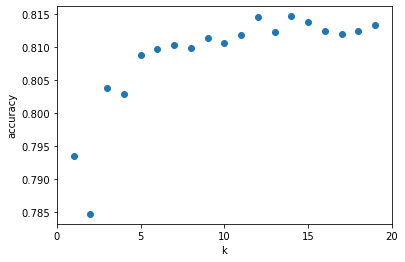

In [146]:
# FIND OUT HIGHEST AVERAGE K

grouped = best_accuracy.groupby("best_k")
accuracies = []

for name,group in grouped:
    accuracies.append(group["best_accuracy"].mean())
    if group["best_accuracy"].mean() == max(accuracies):
        averageK = name
        averageAcc = group["best_accuracy"].mean()

print("k =", averageK, "yields the highest average accuracy of", averageAcc, "after evaluating 10000 train_test splits.")

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, accuracies)
plt.xticks([0,5,10,15,20]);

In [ ]:
# it would be nice to add some error bars to see how much values vary

In [128]:
# TRAIN THE CLASSIFIER
print("based on previous results, k was set to", averageK)

# set train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train the classifier
knn = KNeighborsClassifier(n_neighbors = averageK)
knn.fit(X_train, y_train)

based on previous results, k was set to 19


KNeighborsClassifier(n_neighbors=19)

In [129]:
# EVALUATE ACCURACY OF THE CLASSIFIER
# obligatory: calculate score over test set
# optional: do cross validation
# optional: evaluate proportion of the train/test split proportion
knn.score(X_test, y_test)

0.7978723404255319

In [143]:
# FIND OUT OPTIMUM K FOR CLASSIFIER - CALCULATIONS

# do 10 runs, test values of the accuracy of the classifier for k from 1 to 20
n_range2 = range(1, 10001)

# in each run:
for n in n_range2:
    # do the split
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    # make empty list to contain temporary accuracy results of the run
    scores2 = []
    
    # make and train a classifier
    clf = DecisionTreeClassifier().fit(X_train, y_train)
    # calculate scores and append to the temporary list
    scores2.append(clf.score(X_test, y_test))

    # from temporary list, get best accuracy
    b_acc2 = max(scores2)

    # add the result to the data frame "best_accuracy" containing all of the results after the loop
    data2 = [[b_acc2]]
    append_this2 = pd.DataFrame(data2, columns=["best_accuracy"])
    # first loop: initiate "best_accuracy" to contain complete data. first case becomes first row of complete data frame
    if n == 1:
        best_accuracy2 = append_this2
        # from second loop on: each case becomes a new row of the complete data frame
    else:
        best_accuracy2 = pd.concat([best_accuracy2, append_this2])

print("maximum accuracy is", best_accuracy2.max())
print("average accuracy is", best_accuracy2.mean())

maximum accuracy is best_accuracy    0.882979
dtype: float64
average accuracy is best_accuracy    0.787518
dtype: float64


In [ ]:
# USE THE TRAINED CLASSIFIER TO CLASSIFY NEW PREVIOUSLY UNSEEN OBJECTS (optional)